In [6]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [8]:
REQUIRED_COLUMNS = ['user_id', 'variant', 'conversion', 'platform', 'region', 'timestamp']

In [14]:
def validate_ab_test_data(df):
    missing_cols = [col for col in REQUIRED_COLUMNS if col not in df.columns]
    if missing_cols:
        return False, f"Missing required columns: {', '.join(missing_cols)}"
    return True, "Data is valid"

def run_ab_test(df, variant_col='variant', metric_col='conversion'):
    if df[variant_col].nunique() != 2:
        return {"error": "This function supports only two variants (A/B)."}

    group_a = df[df[variant_col] == 'A'][metric_col]
    group_b = df[df[variant_col] == 'B'][metric_col]

    t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False)

    return {
        "variant_a_mean": round(group_a.mean() * 100, 2),
        "variant_b_mean": round(group_b.mean() * 100, 2),
        "p_value": round(p_value, 4),
        "significant": p_value < 0.05
    }

def generate_summary(result):
    if "error" in result:
        return result["error"]

    a_mean = result['variant_a_mean']
    b_mean = result['variant_b_mean']
    p_value = result['p_value']
    significant = result['significant']

    summary = (
        f"Variant A had a conversion rate of {a_mean}%. "
        f"Variant B had a conversion rate of {b_mean}%. "
    )

    if significant:
        summary += (
            f"This difference is statistically significant at the 95% confidence level "
            f"(p = {p_value}).\n\n"
        )
        if b_mean > a_mean:
            summary += "✅ Recommendation: Variant B is better based on the test results.\n"
        else:
            summary += "✅ Recommendation: Variant A is better based on the test results.\n"
    else:
        summary += (
            f"This difference is not statistically significant at the 95% confidence level "
            f"(p = {p_value}).\n"
        )
        summary += "⚠️ No clear winner: We recommend collecting more data or refining your test."

    return summary


In [10]:
def plot_conversion_rates(df, result):
    a_mean = result['variant_a_mean']
    b_mean = result['variant_b_mean']

    fig, ax = plt.subplots(figsize=(6, 4))
    variants = ['Variant A', 'Variant B']
    values = [a_mean, b_mean]
    bars = ax.bar(variants, values, color=['#4caf50', '#2196f3'])

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10)

    ax.set_title("Conversion Rate Comparison")
    ax.set_ylabel("Conversion Rate (%)")

    if result.get("significant", False):
        subtitle = f"Statistically significant (p = {result['p_value']})"
    else:
        subtitle = f"Not statistically significant (p = {result['p_value']})"

    plt.suptitle(subtitle, fontsize=10, y=0.92)
    plt.tight_layout()
    plt.show()


🧪 Validation: Data is valid

📊 A/B Test Summary:
 Variant A had a conversion rate of 11.2%. Variant B had a conversion rate of 18.8%. This difference is statistically significant at the 95% confidence level (p = 0.0173).

✅ Recommendation: Variant B is better based on the test results.



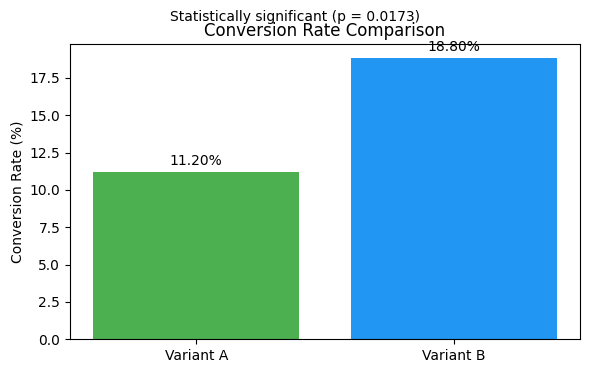

In [15]:
# ✅ Load and test
df = pd.read_csv("data/sample_ab_test.csv")  # Adjust path if needed
valid, message = validate_ab_test_data(df)
print("🧪 Validation:", message)

if valid:
    result = run_ab_test(df)
    summary = generate_summary(result)
    print("\n📊 A/B Test Summary:\n", summary)
    plot_conversion_rates(df, result)
